# Working with a new (glider) dataset

**Aim:** To look at a new dataset and assess whether you think there may be any problems.

**Learning outcomes:** Using what you've learned so far, you will apply this knowledge to a new dataset that you haven't previously encountered.  You will be able to apply your knowledge of sensor response, ocean-knowing-measurements, and python to articulate (and quantify) a possible issue with a dataset.  You will also see an example of how data can be loaded from the internet directly into python.

**Data:** You will work with data from [Voice of the Ocean (VOTO)](https://voiceoftheocean.org) collected in the Baltic Sea.  

**Directions:** Run the python code step by step, and use it to 

**Measure of success:** You will have created a python notebook, a netCDF file (*not* added to the git repository) and the 5 figures exported as `*.png` format into your folder; these will be "commited" and "pushed" to the shared repository, and viewable by everyone.  Additionally, copy your 2 best figures to the `shared_figures/` folder for discussion.  

<hr>

## Update your environment

Your environment will need to contain:
- matplotlib
- pandas
- tqdm
- xarrray
- cmocean
- erddapy
- argopy

````{note}
**If you're using conda to manage your environment:** If these aren't all already in your environment, and you're using `conda` to manage your enviroment, then you can first activate your environment (mine is called `seaocn_env`), then you can run

```{python}
conda activate seaocn_env
conda install --channel conda-forge erddapy argopy cmocean tqdm
```

**If you aren't using conda:** Then you can simply install the missing packages using your usual routines (may be `pip install erddapy`)


You may need to restart your kernal and/or jupyter-lab in order to run with the new packages in your kernel.
````



In [17]:
import matplotlib.dates as mdates
from matplotlib import style
import matplotlib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import ast
import datetime
from tqdm import tqdm
import xarray as xr
from cmocean import cm as cmo
import sys


## Structure of this python notebook:

0. ERDDAP-How to access data
1. Åland sea data
2. Baltic Inflow
3. Hans Storm
4. Spring blooms and annual cycle
5. Issue with CTD data

# 0. ERDDAP-How to access data 
We need some functions in untils to download data from ERDDAP
You need to have erddap_demo on your computer 


https://github.com/voto-ocean-knowledge/erddap_demo use git clone to get this on your computer and the adjust the path in order to import all the functions OR simply download `utils.py`.

After doing this, I've renamed it on my computer to `erddaputils.py` since `utils.py` is a fairly common package name, and I wanted to make sure I was importing the right file.

Observations portal VOTO https://observations.voiceoftheocean.org/

In [18]:
#sys.path.append('C:\\Users\\u241346\\uni_hamburg\\erddap_demo')
sys.path.append('/Users/eddifying/Library/Mobile Documents/com~apple~CloudDocs/Work/teaching/SeaOcn-UHH/2024-SeaOcn/05-github/erddap_demo')
import erddaputils as utils

## Got an error?

If you got an error trying to `import utils` (or after renaming, `import erddaputils`) it may be because the file is not available on your "path".  The "path" is all the places that python will search for the file.  Update your path using `sys.path.append` OR move `utils.py` (or `erddaputils.py`) to your working directory.  Or, if you haven't already renamed `utils.py` from this github package, then try renaming it since your python may be trying to load a `utils.py` from somewhere else.

Note that when you copy it, you will want the actual code (if you open `utils.py` it should look like python code).  If you have a bunch of stuff that looks like HTML (i.e., lines that start with `<` and end with `>`) then you haven't copied the raw file, so try again.

<hr>

## Load the metadata

In the next section, we will download the metadata for the VOTO data to find datasets we're interested in.


In [19]:
e = utils.init_erddap()

# Fetch dataset list of all dataset existing
e.response = "csv"
e.dataset_id = "allDatasets"
df_datasets = e.to_pandas(parse_dates=['minTime (UTC)', 'maxTime (UTC)'])

print(f"found {len(df_datasets)} datasets")

found 499 datasets


In [20]:
# drop the allDatasets row and make the datasetID the index for easier reading
df_datasets.set_index("datasetID", inplace=True)
df_datasets.drop("allDatasets", inplace=True)

# Get only nrt data (near real time) and not delayed as otherwise it would be very long for an intial data exploration
df_datasets = df_datasets[df_datasets.index.str[:3] == "nrt"]
ds_meta = {}
for dataset_id in tqdm(df_datasets.index):
    ds_meta[dataset_id] = utils.get_meta(dataset_id)

100%|████████████████████████████████████████████████████████████████████████████████| 197/197 [02:23<00:00,  1.37it/s]


```{seealso}
Stats to see where data is available and since when: https://observations.voiceoftheocean.org/stats
```

We just downloaded info on all data so that now we can just find the specific datasets we want based on specific criteria

## 1. Download the glider data

### Åland sea data

Åland Sea or the Sea of Åland is between Sweden and Finland.  It's a narrow strait with  stratification and  currents.

In [5]:
# Create a list of the datasets available in this region
name=[]
for dataset_id, meta in ds_meta.items():
    if meta['deployment_start']>'2023-02-01':
        if 'Åland' in meta['basin']:
            name.append(dataset_id)
print(f'Found {len(name)} datasets in Åland: {name}')

Found 5 datasets in Åland: ['nrt_SEA076_M21', 'nrt_SEA076_M24', 'nrt_SEA077_M29', 'nrt_SEA056_M68', 'nrt_SEA078_M24']


In [6]:
print(name)
print(xr.__version__)

['nrt_SEA076_M21', 'nrt_SEA076_M24', 'nrt_SEA077_M29', 'nrt_SEA056_M68', 'nrt_SEA078_M24']
2024.3.0


In [8]:
# Download the glider dataset using the optional argument `nrt_only=True`
ds_nrt = utils.download_glider_dataset(name, nrt_only=True) 

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 46.12it/s]

**Near-real time vs delayed-mode data**

In this exercise, we will only use near-real time (NRT) data and not delayed mode as it would be way slower otherwise.

NRT data from the VOTO gliders generally contain only one file every 3-4 hours (last dive of 2-12 multi-dives).  The CTD data are additionally subsampled to datapoints every 30 seconds (instead of the nominal time interval of 1 second).

In deep areas such as the Åland sea, this means that in the NRT files we have approximately every other dive with 30s data. In shallower locations (e.g., the Bornholm basin), we may get one data file every 6-8 dives at 30s time-resolution.

In areas with a more complex bathymetry as the Kattegat/Skagerrak area where the glider dives as deep as 200m in the north and as shallow as 40m in the south, we then receive files every 2 to 12 dives for the NRT dataset. 

### Inspect the data

To start with, let's take a look at our data.  We can do this by simply printing to the screen once we know which dataset we're looking for.

Compare the two commands, to see what different information/display formats you get:
```python
ds_nrt['nrt_SEA076_M21']
```
and then separately,
```python
print(ds_nrt['nrt_SEA076_M21']
```


Take a look at the metadata and structure of the data.

1. What type are the data?

<!--xarray DataArray-->

2. What is the "dimension", and how long is it?

<!--time, and 40510-->

3. What is the variable name for temperature?  for salinity?  for depth?

<!--temperature, salinity, depth-->

Do you get different information if you do the following commands?
```python
ds_nrt['nrt_SEA076_M21'].keys()
list(ds_nrt['nrt_SEA076_M21'].coords)
list(ds_nrt['nrt_SEA076_M21'].data_vars)
print(ds_nrt['nrt_SEA076_M21'].dims)
```


In [9]:
list(ds_nrt['nrt_SEA078_M24'].data_vars)

['ad2cp_beam1_cell_number1',
 'ad2cp_beam2_cell_number1',
 'ad2cp_beam3_cell_number1',
 'ad2cp_beam4_cell_number1',
 'ad2cp_heading',
 'ad2cp_pitch',
 'ad2cp_pressure',
 'ad2cp_roll',
 'ad2cp_time',
 'altimeter',
 'angular_cmd',
 'angular_pos',
 'backscatter_raw',
 'backscatter_scaled',
 'ballast_cmd',
 'ballast_pos',
 'cdom',
 'cdom_raw',
 'chlorophyll',
 'chlorophyll_qc',
 'chlorophyll_raw',
 'conductivity',
 'conductivity_qc',
 'dead_reckoning',
 'declination',
 'density',
 'density_qc',
 'desired_heading',
 'distance_over_ground',
 'dive_num',
 'heading',
 'internal_pressure',
 'internal_temperature',
 'linear_cmd',
 'linear_pos',
 'nav_resource',
 'nav_state',
 'oxygen_concentration',
 'oxygen_concentration_qc',
 'particulate_backscatter',
 'pitch',
 'potential_density',
 'potential_density_qc',
 'potential_temperature',
 'potential_temperature_qc',
 'pressure',
 'profile_direction',
 'profile_num',
 'roll',
 'salinity',
 'salinity_qc',
 'security_level',
 'temperature',
 'tempera

## Concatenate datasets

From above, we see that there were five missions of gliders to the Åland Sea.  Rather than dealing with them separately, let's put them all together in a single xarray DataArray.

In [10]:
for i in range(len(name)):
#for i in [0, 1, 4]:
        
    print(name[i])
        #list(ds_nrt[name[i]]))

nrt_SEA076_M21
nrt_SEA076_M24
nrt_SEA077_M29
nrt_SEA056_M68
nrt_SEA078_M24


In [11]:
# Initialise a dataset as empty
full_data = []

# Cycle through each of the glider datasets listed in `name`
for i in range(len(name)):
#for i in [4]:
    
    # For each dataset, append it to the data in full_data (starts empty, and grows)
    full_data.append(ds_nrt[name[i]])

# Concatenate datasets together along the time dimension
full_data = xr.concat(full_data, dim= 'time')

In [12]:
xr.show_versions()


INSTALLED VERSIONS
------------------
commit: None
python: 3.11.8 | packaged by conda-forge | (main, Feb 16 2024, 20:49:36) [Clang 16.0.6 ]
python-bits: 64
OS: Darwin
OS-release: 23.4.0
machine: arm64
processor: arm
byteorder: little
LC_ALL: None
LANG: en_GB.UTF-8
LOCALE: ('en_GB', 'UTF-8')
libhdf5: 1.14.3
libnetcdf: 4.9.2

xarray: 2024.3.0
pandas: 2.2.1
numpy: 1.26.4
scipy: 1.13.0
netCDF4: 1.6.5
pydap: None
h5netcdf: None
h5py: None
Nio: None
zarr: None
cftime: 1.6.3
nc_time_axis: None
iris: None
bottleneck: 1.3.8
dask: 2024.4.1
distributed: 2024.4.1
matplotlib: 3.8.3
cartopy: None
seaborn: None
numbagg: None
fsspec: 2024.3.1
cupy: None
pint: None
sparse: None
flox: None
numpy_groupies: None
setuptools: 69.2.0
pip: 24.0
conda: None
pytest: None
mypy: None
IPython: 8.21.0
sphinx: 7.2.6


/Users/eddifying/micromamba/envs/seaocn_env/lib/python3.11/site-packages/_distutils_hack/__init__.py:26: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")


## 2. Baltic inflow 

What are Baltic Inflows?

The deep water in the Baltic Proper is renewed during specific conditions: when salt water from the Kattegat flows through the Belt and the Sound, and fills in turn the deep areas of the Arkona Basin, the Bornholm Basin, the Eastern Gotland Basin and the western Gotland Basin. They manifest as bottom gravity currents.

The Baltic Sea is a very enclosed sea characterized by brakish waters, and salt water only enters through the narrow Danish straits. Water masses change in the upper layers and interlayer, but not near the bottom. The deep waters of the Baltic sea are anoxic. When large amounts of salty water from the North Sea enters the Baltic, this salty and dense oxygen-rich water can replace the anoxic deep water. Such events are called Major Baltic Inflows (MBI) which are a necessary phenomena as they allow oxygen to be replenished in the deepest parts of the Baltic.

Detecting Baltic inflows with observations can be a challenge. The short duration of the inflows (2–3 weeks) poses a challenge to traditional ﬁeld measurements.  As a consequence, the BIs are prone to undersampling and difﬁcult to predict. Since regular monitoring cruises in the Baltic Sea typically occur monthly or less frequently, the likelihood of missing or only partially resolving a BI is high.

In December, a Baltic inflow was detected. This recent inflow brought 80 km$^3$ of new salty water into the Baltic Sea, making this event a medium size inflow. 
The last  comparable one was over 5 years ago. The inflow corresponds to 1.6 Gt (1.6 billion t) of salt. This is the first event of this scale since the VOTO observatories started.

Estimated that by the beginning of February, the deep water in Bornholm Basin will be exchanged by the new salty inflow.

```{seealso}
https://news.err.ee/1609206383/rare-saltwater-inflow-in-baltic-sea-could-have-widespread-environmental-impactter.
```


In [13]:
# We want to find data from the Bornholm Basin (the first basin after the Danish straits) from early December 2023 until now

name=[]
for dataset_id, meta in ds_meta.items():
    if meta['deployment_end']>'2023-12-01':
        if 'Bornholm' in meta['basin']:
            name.append(dataset_id)
print(f'Found {len(name)} datasets in Bornholm: {name}')

Found 7 datasets in Bornholm: ['nrt_SEA068_M30', 'nrt_SEA063_M69', 'nrt_SEA063_M71', 'nrt_SEA063_M72', 'nrt_SEA067_M51', 'nrt_SEA067_M53', 'nrt_SEA067_M55']


In [14]:
ds_nrt = utils.download_glider_dataset(name, nrt_only=True)

  0%|                                                                                            | 0/7 [00:00<?, ?it/s]

 14%|████████████                                                                        | 1/7 [00:00<00:02,  2.02it/s]

 29%|████████████████████████                                                            | 2/7 [00:01<00:02,  1.99it/s]

 43%|████████████████████████████████████                                                | 3/7 [00:01<00:02,  1.59it/s]

 57%|████████████████████████████████████████████████                                    | 4/7 [00:02<00:01,  1.84it/s]

 71%|████████████████████████████████████████████████████████████                        | 5/7 [00:02<00:01,  1.86it/s]

 86%|████████████████████████████████████████████████████████████████████████            | 6/7 [00:03<00:00,  1.84it/s]

100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:03<00:00,  1.88it/s]


NameError: name 'matplotlib' is not defined

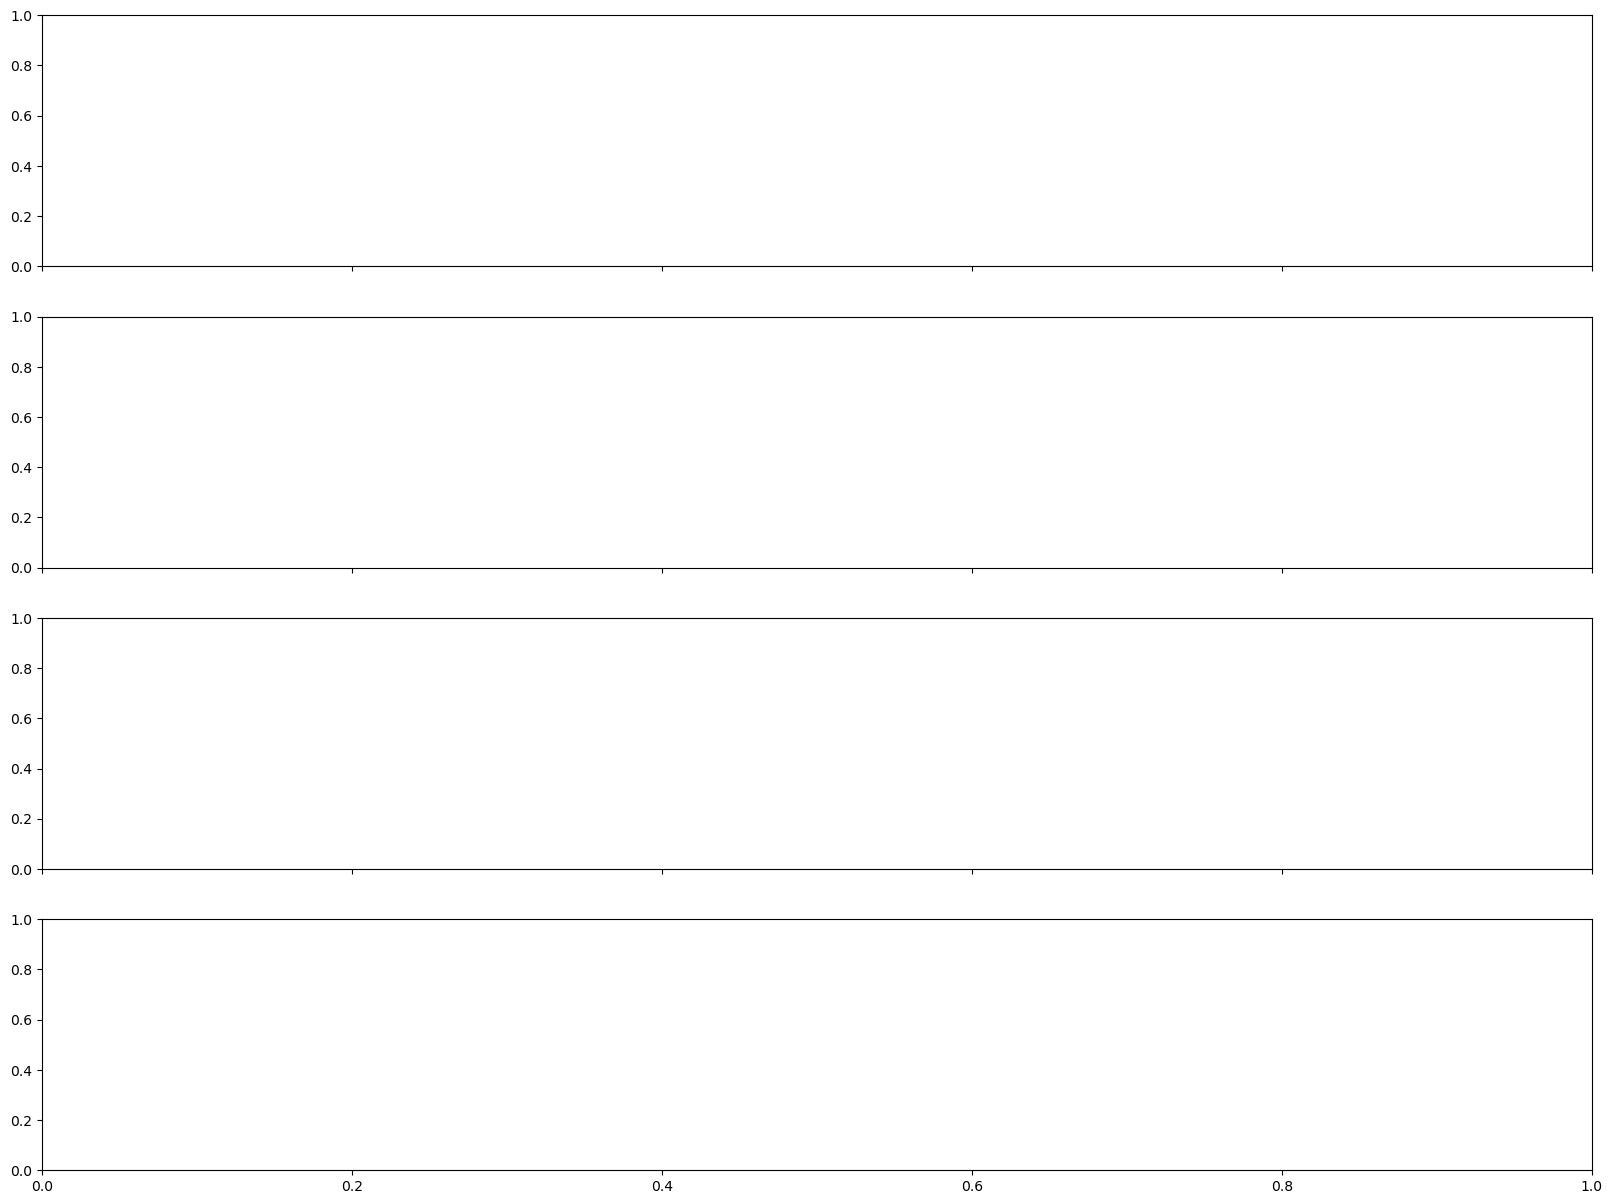

In [15]:
full_data = []
for i in range(len(name)):
    full_data.append(ds_nrt[name[i]])
full_data = xr.concat(full_data, dim= 'time')

fig, ax = plt.subplots(4,1,figsize=(20, 15), sharex=True)
matplotlib.rcParams.update({'font.size': 18})
time=mdates.date2num(full_data.time)
t=ax[0].scatter( time,full_data.depth, c=full_data.temperature,s=20, cmap=cmo.thermal, vmin=np.nanpercentile(full_data.temperature, 0.5), vmax=np.nanpercentile(full_data.temperature, 99.5))
s=ax[1].scatter( time,full_data.depth, c=full_data.salinity,s=20,cmap=cmo.haline, vmin=np.nanpercentile(full_data.salinity, 0.5), vmax=np.nanpercentile(full_data.salinity, 99.5))
d=ax[2].scatter( time,full_data.depth, c=full_data.density, s=20, cmap=cmo.dense, vmin=np.nanpercentile(full_data.density, 0.5), vmax=np.nanpercentile(full_data.density, 99.5))
o=ax[3].scatter( time,full_data.depth, c=full_data.oxygen_concentration,cmap=cmo.matter, s=20,vmin=np.nanpercentile(full_data.oxygen_concentration, 0.5), vmax=np.nanpercentile(full_data.oxygen_concentration, 99.5))

[a.set_ylim(90,-10) for a in ax]
[a.grid() for a in ax]
ax[1].xaxis.reset_ticks()
ax[1].xaxis.set_major_locator(mdates.WeekdayLocator(byweekday = 1, interval=3))
ax[1].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))


cbarT=plt.colorbar(t, ax=ax[0], pad = 0.03)
cbarT.set_label('Potential \nTemperature \n(°C)',labelpad=70, y=0.5, rotation=270,fontsize=18)
cbarS=plt.colorbar(s, ax=ax[1], pad = 0.03)
cbarS.set_label('Absolute \nSalinity \n(g kg$^{-1}$)',labelpad=70, y=0.5, rotation=270,fontsize=18)
cbarD=plt.colorbar(d, ax=ax[2], pad = 0.03)
cbarD.set_label('Potential \nDensity \n(kg m$^{-3}$)',labelpad=70, y=0.5, rotation=270,fontsize=18)
cbarO=plt.colorbar(o, ax=ax[3], pad = 0.03)
cbarO.set_label('Oxygen \nconcentration \n(mmol m$^{-3}$)',labelpad=70, y=0.5, rotation=270,fontsize=18)

[a.tick_params(axis='both', which='major', labelsize=18) for a in ax]
[a.set_ylabel('Depth (m)',fontsize=18) for a in ax]

#### Info
There are issues with some of the oxygen data and more info can be found here https://observations.voiceoftheocean.org/static/img/reports/Quality_Issue_1_AROD.pdf

## 3. Hans storm
https://www.krisinformation.se/en/hazards-and-risks/disasters-and-incidents/2023/storm-hans

https://www.theguardian.com/world/2023/aug/08/storm-hans-causes-havoc-in-norway-with-heaviest-rain-in-25-years-forecast

https://www.su.se/department-of-geological-sciences/news/hans-is-the-perfect-storm-globalwarming-contributed-1.664948

During the first week on August 2023 a strong storm hit Sweden and Norway causing big floodings and high water level in multiple areas.

Is it possible to see the effect of the storm on any of the glider data?

In [ ]:
## We look for all the glider data avaialble from early July to end of August
name=[]
for dataset_id, meta in ds_meta.items():
    if meta['deployment_start']>'2023-07-01':
        if meta['deployment_start']<'2023-09-01':
            name.append(dataset_id)
print(f'Found {len(name)} datasets between July 1st 2023 and September 1st 2023: {name}')

In [ ]:
ds_nrt = utils.download_glider_dataset(name, nrt_only=True)

In [ ]:
## We want to see where the data  is from and get a bit more info summarized
table=pd.DataFrame(columns = ['Glider','Location','Mission','Start_Date'])
missions=name
dic=ds_nrt
table.Mission= range(0,len(missions))
    
for i in range(len(missions)): 
    d=dic[missions[i]]
    table.loc[i, 'Glider']=f'SEA0{int(d.attrs["glider_serial"])}'
    table.loc[i,'Mission']=int(d.attrs["deployment_id"])
    table.loc[i, 'Start_Date']=d.attrs["deployment_start"][:10]
    table.loc[i,'Location']=d.attrs["basin"]


table.sort_values(by=["Start_Date"], ascending=True)

In [ ]:
print(f'We have data from {len(table.Location.unique())} different sites during this period: {table.Location.unique()}')

In [ ]:
# We can try to plot data and see if anything is visible in any of the 4 areas

In [ ]:
def plot_sel_data(basin='Bornholm', date_start='2023-07-01', date_end='2023-09-01', rectangle=True,  delayed = False):
    
    name=[]
    for dataset_id, meta in ds_meta.items():
        if meta['deployment_start']>date_start:
            if meta['deployment_start']<date_end:
                if basin in meta['basin']:
                    if 'SAMBA' in meta['project']:
                        if delayed == True:
                            name.append(f'delayed{dataset_id[3:]}')
                        else:
                            name.append(dataset_id)
    
        
    ds_nrt = utils.download_glider_dataset(name, nrt_only=False)
    
    full_data = []
    for i in range(len(name)):
        full_data.append(ds_nrt[name[i]])
    full_data = xr.concat(full_data, dim= 'time')
    
    fig, ax = plt.subplots(5,1,figsize=(20, 15), sharex=True)
    
    time=mdates.date2num(full_data.time)
    t=ax[0].scatter( time,full_data.depth, c=full_data.temperature,s=20, cmap=cmo.thermal, vmin=np.nanpercentile(full_data.temperature, 0.5), vmax=np.nanpercentile(full_data.temperature, 99.5))
    s=ax[1].scatter( time,full_data.depth, c=full_data.salinity,s=20,cmap=cmo.haline, vmin=np.nanpercentile(full_data.salinity, 0.5), vmax=np.nanpercentile(full_data.salinity, 99.5))
    d=ax[2].scatter( time,full_data.depth, c=full_data.density, s=20, cmap=cmo.dense, vmin=np.nanpercentile(full_data.density, 0.5), vmax=np.nanpercentile(full_data.density, 99.5))
    o=ax[3].scatter( time,full_data.depth, c=full_data.oxygen_concentration, s=20,vmin=np.nanpercentile(full_data.oxygen_concentration, 0.5), vmax=np.nanpercentile(full_data.oxygen_concentration, 99.5))
    c=ax[4].scatter( time,full_data.depth, c=full_data.chlorophyll, s=20, cmap=cmo.algae, vmin=np.nanpercentile(full_data.chlorophyll, 0.5), vmax=np.nanpercentile(full_data.chlorophyll, 99.5))
    
    # Highlight storm period
    if rectangle:
        for a in ax: 
            rect = patches.Rectangle((int(mdates.date2num(['2023-08-07'])[0]), int(full_data.depth.max())), 5, 3, linewidth=5, edgecolor='r', facecolor='red', fill='red')
            a.add_patch(rect) 
    
    [a.set_ylim(int(full_data.depth.max())+5,-10) for a in ax]
    [a.grid() for a in ax]

    ax[4].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    ax[4].locator_params(axis='x', nbins=8) 
    
    cbarT=plt.colorbar(t, ax=ax[0], pad = 0.03)
    cbarT.set_label('Potential \nTemperature \n(°C)',labelpad=70, y=0.5, rotation=270,fontsize=18)
    cbarS=plt.colorbar(s, ax=ax[1], pad = 0.03)
    cbarS.set_label('Absolute \nSalinity \n(g kg$^{-1}$)',labelpad=70, y=0.5, rotation=270,fontsize=18)
    cbarD=plt.colorbar(d, ax=ax[2], pad = 0.03)
    cbarD.set_label('Potential \nDensity \n(kg m$^{-3}$)',labelpad=70, y=0.5, rotation=270,fontsize=18)
    cbarO=plt.colorbar(o, ax=ax[3], pad = 0.03)
    cbarO.set_label('Oxygen \nconcentration \n(mmol m$^{-3}$)',labelpad=70, y=0.5, rotation=270,fontsize=18)
    cbarC=plt.colorbar(c, ax=ax[4], pad = 0.03)
    cbarC.set_label('Chlorophyll \n(mg m$^{-3}$)',labelpad=70, y=0.5, rotation=270,fontsize=18)
    
    [a.tick_params(axis='both', which='major', labelsize=18) for a in ax]
    [a.set_ylabel('Depth (m)',fontsize=18) for a in ax]
    


In [ ]:
plot_sel_data(basin='Bornholm',date_start='2023-07-01', date_end='2023-09-01',)

In [ ]:
plot_sel_data(basin='Eastern Gotland',date_start='2023-07-01', date_end='2023-09-01')

In [ ]:
plot_sel_data(basin='Western Gotland',date_start='2023-07-01', date_end='2023-09-01')

In [ ]:
plot_sel_data(basin='Kattegat', date_start='2023-07-01', date_end='2023-09-01')

In [ ]:
## Temperature and salinity for Western Gotland looks weird, let#s check if we see issues in the delayed mode data as well
plot_sel_data(basin='Western Gotland',date_start='2023-07-01', date_end='2023-09-01', delayed=True)

## 4. Spring blooms

In [ ]:
plot_sel_data(basin='Bornholm',date_start='2023-01-01', date_end='2024-01-01',rectangle=False)

#### Info
There are issues with some of the oxygen data and more info can be found here https://observations.voiceoftheocean.org/static/img/reports/Quality_Issue_1_AROD.pdf

In [ ]:
plot_sel_data(basin='Eastern Gotland',date_start='2023-01-01', date_end='2024-01-01',rectangle=False)

In [ ]:
plot_sel_data(basin='Skagerrak',date_start='2023-01-01', date_end='2024-01-01',rectangle=False)

## 5. Specific data with issues

In [ ]:
# SEA070 with pumped SeaBird CTD
name = ['delayed_SEA070_M15', 'delayed_SEA070_M15']
ds_delayed = utils.download_glider_dataset(name, nrt_only=False)

In [ ]:
full_data = []
for i in range(len(name)):
    full_data.append(ds_delayed[name[i]])
full_data = xr.concat(full_data, dim= 'time')

fig, ax = plt.subplots(5,1,figsize=(20, 15), sharex=True)
matplotlib.rcParams.update({'font.size': 18})
time=mdates.date2num(full_data.time)
t=ax[0].scatter( time,full_data.depth, c=full_data.temperature,s=20, cmap=cmo.thermal, vmin=np.nanpercentile(full_data.temperature, 0.5), vmax=np.nanpercentile(full_data.temperature, 99.5))
s=ax[1].scatter( time,full_data.depth, c=full_data.salinity,s=20,cmap=cmo.haline, vmin=np.nanpercentile(full_data.salinity, 0.5), vmax=np.nanpercentile(full_data.salinity, 99.5))
d=ax[2].scatter( time,full_data.depth, c=full_data.density, s=20, cmap=cmo.dense, vmin=np.nanpercentile(full_data.density, 0.5), vmax=np.nanpercentile(full_data.density, 99.5))
o=ax[3].scatter( time,full_data.depth, c=full_data.oxygen_frequency, s=20,vmin=np.nanpercentile(full_data.oxygen_frequency, 0.5), vmax=np.nanpercentile(full_data.oxygen_frequency, 99.5))
c=ax[4].scatter( time,full_data.depth, c=full_data.chlorophyll, s=20, cmap=cmo.algae, vmin=np.nanpercentile(full_data.chlorophyll, 0.5), vmax=np.nanpercentile(full_data.chlorophyll, 99.5))
    
[a.set_ylim(int(full_data.depth.max()+10),-10) for a in ax]
[a.grid() for a in ax]
ax[1].xaxis.reset_ticks()
ax[1].xaxis.set_major_locator(mdates.WeekdayLocator(byweekday = 1, interval=3))
ax[1].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))


cbarT=plt.colorbar(t, ax=ax[0], pad = 0.03)
cbarT.set_label('Potential \nTemperature \n(°C)',labelpad=70, y=0.5, rotation=270,fontsize=18)
cbarS=plt.colorbar(s, ax=ax[1], pad = 0.03)
cbarS.set_label('Absolute \nSalinity \n(g kg$^{-1}$)',labelpad=70, y=0.5, rotation=270,fontsize=18)
cbarD=plt.colorbar(d, ax=ax[2], pad = 0.03)
cbarD.set_label('Potential \nDensity \n(kg m$^{-3}$)',labelpad=70, y=0.5, rotation=270,fontsize=18)
cbarO=plt.colorbar(o, ax=ax[3], pad = 0.03)
cbarO.set_label('Oxygen \nconcentration \n(mmol m$^{-3}$)',labelpad=70, y=0.5, rotation=270,fontsize=18)
cbarC=plt.colorbar(c, ax=ax[4], pad = 0.03)
cbarC.set_label('Chlorophyll \n(mg m$^{-3}$)',labelpad=70, y=0.5, rotation=270,fontsize=18)

[a.tick_params(axis='both', which='major', labelsize=18) for a in ax]
[a.set_ylabel('Depth (m)',fontsize=18) for a in ax]

## This is all raw data and many adjustments have to be applied and various issues soruces should be considered
* Thermal hysteresis
* Quenching corrections
* Calibration (ex. optics dark count correction and scaling factor correction, oxygen calibration etc..)
* Electrical spikes
* Outliers
* Sensor failure
* Specific sensor issues (FLBBPC issues, FLBBCD issues, AROD and CODA issues)
* 
